In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import json
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib

#
#data_file_name='data/sacct_mazama_out_2.out'
data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'

In [3]:
load_pickle = True
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_mazama=pickle.load(fin)
    #
else:
    sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
    #
    
    with open(pkl_name, 'wb') as fout:
            #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
            out_pkl = pickle.dump(sacct_mazama, fout)
#

In [4]:
print('doing anything?')

#ls -l data/*.pkl

doing anything?


In [5]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]))

*** max_submit: 2020-05-06 14:47:13+00:00, max_start: 2020-05-06 14:47:13+00:00


In [6]:
#
#cpu_usage = sacct_mazama.active_jobs_cpu()
cpu_usage = sacct_mazama.cpu_usage
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=None)

In [7]:
print('** ', len(cpu_usage['time']))
print('** ** ', sacct_mazama.data[0:5])
print('** ', sacct_mazama.data.dtype)

**  5000
** **  [(0, 'rmorsini', 'users', '100', 'bash', '67', '67', 'ere', 'COMPLETED',  7.,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00.011', '00:00.007', '00:00.018', None, '8', '00:00:00', '67')
 (1, None, None, None, 'extern', '67.extern', '67.extern', None, 'COMPLETED', nan,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00:00', '00:00.001', '00:00.001', '1', '8', '00:00:00', '67')
 (2, None, None, None, 'bash', '67.0', '67.0', None, 'COMPLETED', nan,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00.011', '00:00.005', '00:00.016', '1', '8', '00:00:00', '67')
 (3, 'rmorsini', 'users', '100', 'UOF_TES', '68', '68', 'suprib', 'FAILED',  7., 200, 10, 737407.9724537 , 737407.9724537 , 737407.9724537 , 737407.97246528, 1.15740741e-05, '00:00.007', '00:00.006', '00:00.013', None, '200', '00:00:00', '68')
 (4, None, None, None, 'batc

[Text(737375.0, 0, '2019-11-12'),
 Text(737400.0, 0, '2019-12-7'),
 Text(737425.0, 0, '2020-1-1'),
 Text(737450.0, 0, '2020-1-26'),
 Text(737475.0, 0, '2020-2-20'),
 Text(737500.0, 0, '2020-3-16'),
 Text(737525.0, 0, '2020-4-10'),
 Text(737550.0, 0, '2020-5-5'),
 Text(737575.0, 0, '2020-5-30'),
 Text(737600.0, 0, '2020-6-24')]

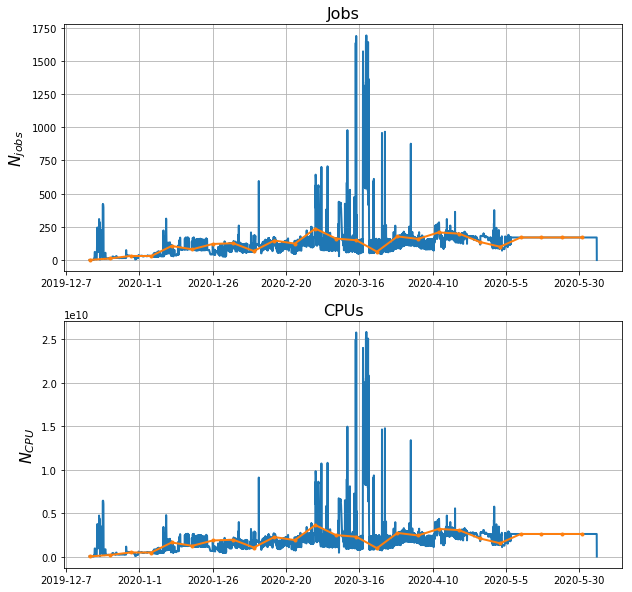

In [8]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [9]:
def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .75]):
    # NOTE: this is not quite general purpose. it takes the input%1, then converts the fractional remainder
    #. (modulus) to an integer(ish) by multiplying. Aka, t%1 gives the remaining fraction of a day (by standard
    #. python date conventions); (t%1)*24 gives that in hours. But to convert this to DoW, we first have 
    #. to convert the numerical date to weeks, so we'd want (t-t_0)%7, or we could use this function, but
    #. pass t=t_days/7., bin_mod=7, and really we'd want to do a phase shif to get DoW correctly.
    XY=numpy.array(XY)
    if XY.shape[0]==2:
        X = XY[0,:]
        Y = XY[1:]
    else:
        X = XY[:,0]
        Y = XY[:,1]
    #
    #X_mod = ((X*bin_mod)%bin_mod).astype(int)
    X_mod = ((X%1.)*bin_mod).astype(int)
    #
    stats_output=[]
    for x in numpy.unique(X_mod):
        ix = X_mod==x
        this_Y = Y[ix]
        stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
                                      numpy.quantile(this_Y, qs))]
    #
    # TODO: convert this to a structured array. it looks (mostly) just like a record array, but it's not...
    #.  and it's faster...
    return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
                                                        ('stdev', '>f8')] + 
                                         [('q_{}'.format(q), '>f8') for q in qs])
#

    

In [10]:
def instant_usage_report(qs=[.45, .5, .55], figsize=(14,10), cpu_usage=cpu_usage):
    # DEPRICATION: moved to hpc_lib.SACCT_data_handler
    fg = plt.figure(figsize=(14,10))
    #
    ax1 = fg.add_subplot('231')
    ax2 = fg.add_subplot('232')
    ax3 = fg.add_subplot('233')
    ax4 = fg.add_subplot('234')
    ax5 = fg.add_subplot('235')
    ax6 = fg.add_subplot('236')
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    [ax.grid() for ax in axs]
    #
    qs = [.45, .5, .55]
    qs_s = ['q_{}'.format(q) for q in qs]
    print('*** qs_s: ', qs_s)

    cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], 
                                                     cpu_usage['N_cpu']]).T, qs=qs)
    jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'],
                                                      cpu_usage['N_jobs']]).T, qs=qs)
    #
    cpu_weekly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time']/7.,
                                                     cpu_usage['N_cpu']]).T, bin_mod=7., qs=qs)
    jobs_weekly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time']/7.,
                                                      cpu_usage['N_jobs']]).T, bin_mod=7., qs=qs)
    #
    ix_pst = numpy.argsort( (jobs_hourly['x']-7)%24)
    #
    hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
    ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o', label='PST')
    ax2.plot((jobs_hourly['x']), jobs_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')
    ax3.plot(jobs_weekly['x'], jobs_weekly['q_0.5'], ls='-', marker='o', color='b')
    ax3.plot(jobs_weekly['x'], jobs_weekly['mean'], ls='--', marker='', color='b')
    ax3.fill_between(jobs_weekly['x'], jobs_weekly[qs_s[0]], jobs_weekly[qs_s[-1]],
                     alpha=.1, zorder=1, color='b')
    #
    #
    hh4 = ax4.hist(cpu_usage['N_cpu'], bins=25)
    ax5.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o', label='PST')
    ax5.plot( (cpu_hourly['x']), cpu_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')
    ax6.plot(cpu_weekly['x'], cpu_weekly['q_0.5'], ls='-', marker='o', color='b')
    ax6.plot(cpu_weekly['x'], cpu_weekly['mean'], ls='--', marker='', color='b')
    #
    # TODO: can we simplyfy this qs syntax?
    ax6.fill_between(cpu_weekly['x'], cpu_weekly[qs_s[0]], cpu_weekly[qs_s[-1]], alpha=.1, zorder=1, color='b')
    #
    #ax1.set_ylim(-5., 200)
    ax1.set_title('$N_{jobs}$ Histogrm', size=16)
    ax2.set_title('Hour-of-day job counts', size=16)
    ax3.set_title('Day-of-week job counts', size=16)
    #
    ax4.set_title('$N_{cpu}$ Histogram', size=16)
    ax5.set_title('Hour-of-day CPU counts', size=16)
    ax6.set_title('Day-of-week CPU counts', size=16)
    #
    ax5.set_xlabel('Hour of Day (PST)')
    plt.suptitle('Instantaneous Usage ', size=16)
    #
    ax2.legend(loc=0)
    ax5.legend(loc=0)
    #
    for ax in (ax3, ax6):
        ax.set_xticklabels(['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    #
    

In [11]:
#intant_stats = instant_usage_report()


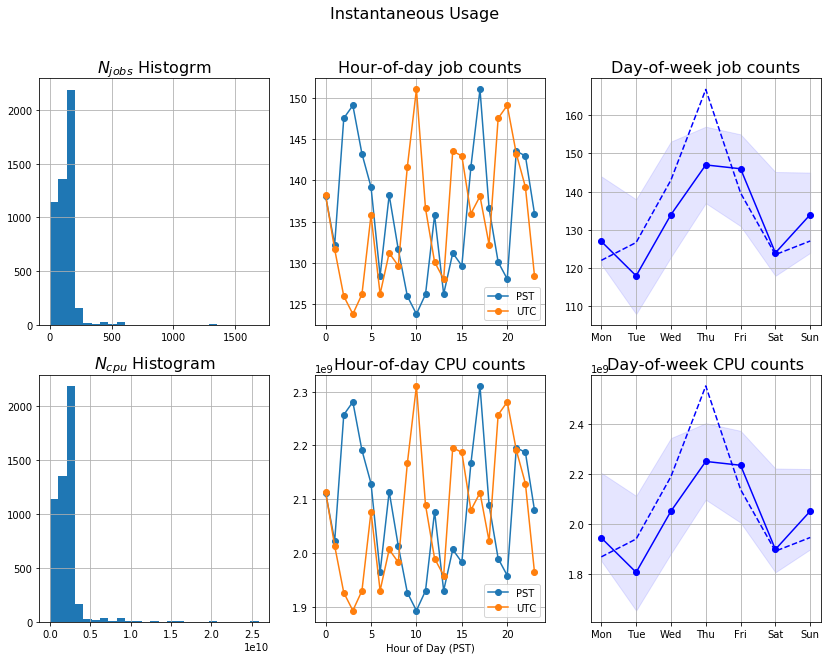

In [12]:
inst_stats = sacct_mazama.active_cpu_jobs_per_day_hour_report()


In [13]:
weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000)

daily_hours = sacct_mazama.get_cpu_hours(bin_size=1, n_points=1000)

** DEBUG: (get_cpu_hours) initial shapes::  (1381096,) (1381096,) (1, 1381096)
** DEBUG: (get_cpu_hours) (1381096,) (1381096,)
***  (1000,)
** DEBUG: (get_cpu_hours) initial shapes::  (1381096,) (1381096,) (1, 1381096)
** DEBUG: (get_cpu_hours) (1381096,) (1381096,)
***  (1000,)


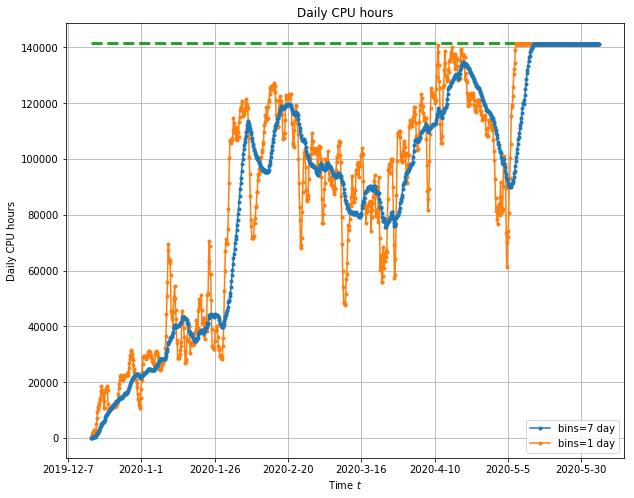

In [14]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)

In [15]:
# how many active nodes do we have? looks like tasks/cpus show up as 1/thread, so 48 per node, so...
n_max = numpy.max(daily_hours['cpu_hours'])
#
n_nodes = n_max/(24.*48.)
#
print('*** n_max={}, n_nodes={}'.format(n_max, n_nodes))
#140000/(24*48)

*** n_max=141168.0, n_nodes=122.54166666666667


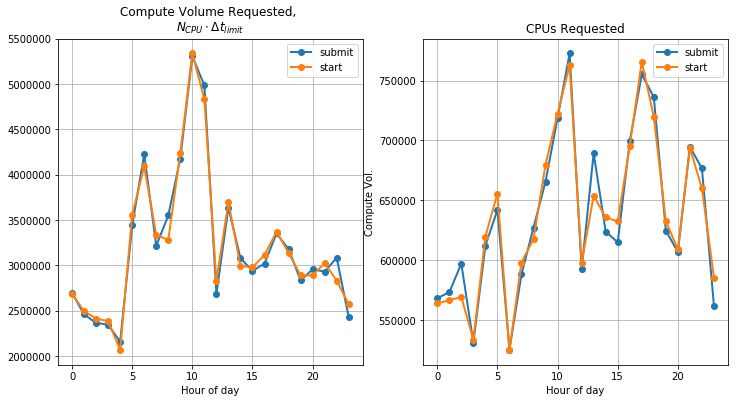

In [16]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = sacct_mazama.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = sacct_mazama.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

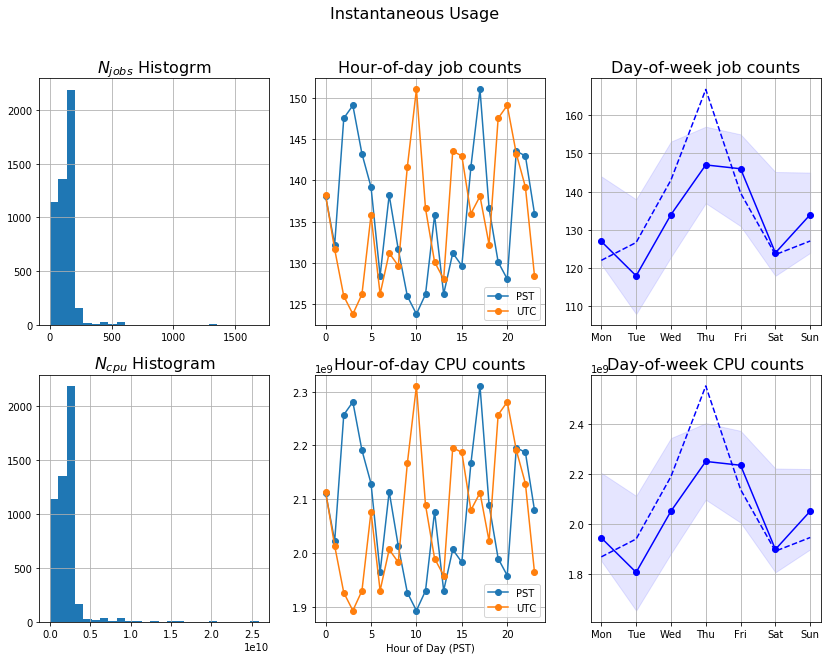

In [30]:
zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=(14,10), cpu_usage=None)

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'JobID_parent')


/Users/myoder96/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '(Cumulative)')

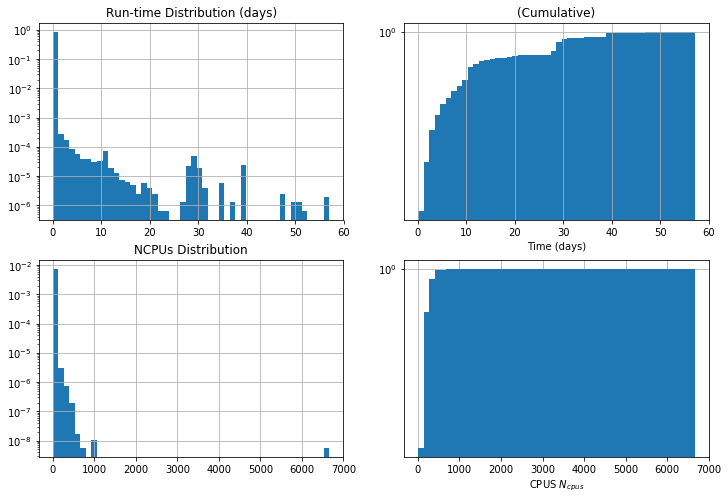

In [17]:
# compute some distributions:
print('*** ', sacct_mazama.jobs_summary.dtype.names)
run_times = sacct_mazama.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
#ax1a.set_yscale('log')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, normed=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, normed=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True)
hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [18]:
print('** ', len(run_times), len(sacct_mazama.jobs_summary['NCPUS']))

**  1380849 1381096


In [19]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(sacct_mazama.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.9990614469793584, 0.999591555629906, 0.9998109858500097
*** N_24/N=0.8401273419468747


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:580: RuntimeWarning: invalid value encountered in greater_equal
  x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]


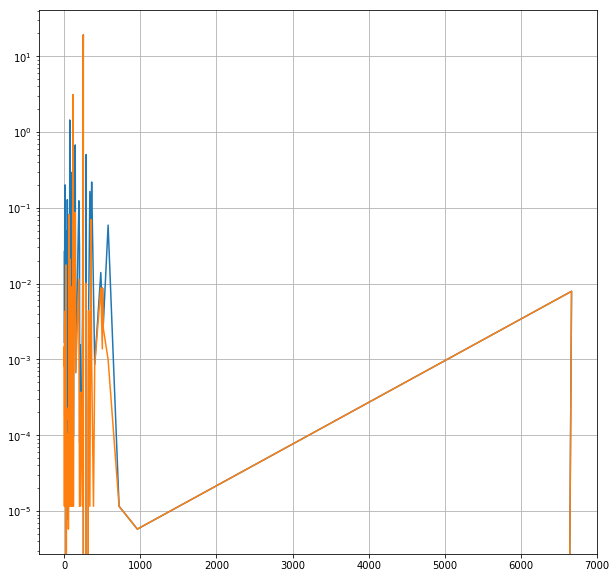

In [20]:
wait_stats = sacct_mazama.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

***  ['2019-12-7', '2019-12-27', '2020-1-16', '2020-2-5', '2020-2-25', '2020-3-16', '2020-4-5', '2020-4-25', '2020-5-15', '2020-6-4', '2020-6-24']


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

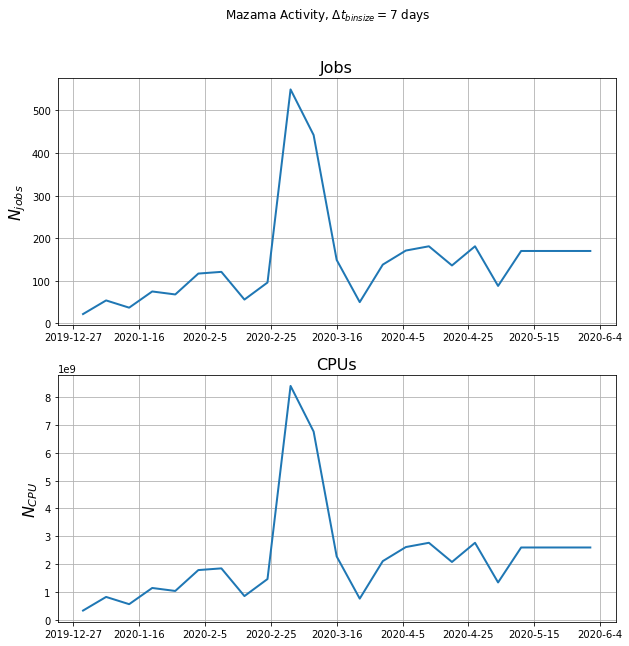

In [21]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


#### Group drill-down stats
- Demo of how to get some sort of PI/group subsets.
- More to come...

** DEBUG: sum(ix=1386)
***  ['2019-12-7', '2019-12-27', '2020-1-16', '2020-2-5', '2020-2-25', '2020-3-16', '2020-4-5', '2020-4-25', '2020-5-15', '2020-6-4', '2020-6-24']


[Text(737400.0, 0, '2019-12-7'),
 Text(737420.0, 0, '2019-12-27'),
 Text(737440.0, 0, '2020-1-16'),
 Text(737460.0, 0, '2020-2-5'),
 Text(737480.0, 0, '2020-2-25'),
 Text(737500.0, 0, '2020-3-16'),
 Text(737520.0, 0, '2020-4-5'),
 Text(737540.0, 0, '2020-4-25'),
 Text(737560.0, 0, '2020-5-15'),
 Text(737580.0, 0, '2020-6-4'),
 Text(737600.0, 0, '2020-6-24')]

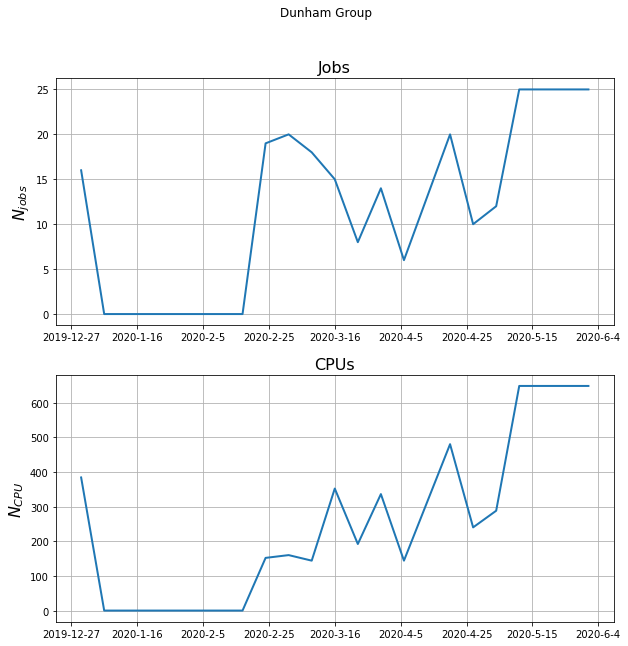

In [25]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in sacct_mazama.jobs_summary['User'] ])
#ix = numpy.array([True for s in sacct_mazama.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
print('** DEBUG: sum(ix={})'.format(numpy.sum(ix)))
#
cpu_weekly_edg = sacct_mazama.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [26]:
# Start with a table of weekly usage by group?
#
with open('mazama_groups.json', 'r') as fin:
    groups = json.load(fin)
#

keys:  dict_keys(['tgp', 'sep', 'clab', 'beroza', 'lnt', 'ds', 'nsd', 'oxyvibtest', 'cardamom', 'crustal', 'stress', 'das', 'ess', 'astro', 'seaf', 'oneill', 'modules', 'wheel', 'ds2', 'shanna', 'issm', 'fs-uq-zechner', 'esitstaff', 'itstaff', 'sac-eess164', 'sac-lab', 'sac-lambin', 'sac-lobell', 'fs-bpsm', 'fs-scarp1', 'fs-erd', 'fs-sedtanks', 'fs-sedtanks-ro', 'fs-supria', 'web-rg-dekaslab', 'fs-cdfm', 'suprib', 'cees', 'suckale', 'schroeder', 'thomas', 'ere', 'smart_fields', 'temp', 'mayotte-collab'])
** DEBUG: sum(ix)=614709165 / len(ix)=1386
** DEBUG: sum(ix)=109737475465 / len(ix)=223065
** DEBUG: sum(ix)=1388451732 / len(ix)=2497
** DEBUG: sum(ix)=654726576509 / len(ix)=787737
** DEBUG: sum(ix)=90805148 / len(ix)=169
** DEBUG: sum(ix)=51038064 / len(ix)=112
** DEBUG: sum(ix)=0 / len(ix)=0
[nsd]:: no records.
** DEBUG: sum(ix)=46177325 / len(ix)=88
** DEBUG: sum(ix)=2564495064 / len(ix)=9497
** DEBUG: sum(ix)=0 / len(ix)=0
[crustal]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[

/Users/myoder96/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


** DEBUG: sum(ix)=0 / len(ix)=0
[seaf]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[oneill]:: no records.
** DEBUG: sum(ix)=70911843 / len(ix)=163
** DEBUG: sum(ix)=70911843 / len(ix)=163
** DEBUG: sum(ix)=46177325 / len(ix)=88
** DEBUG: sum(ix)=0 / len(ix)=0
[shanna]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[issm]:: no records.
** DEBUG: sum(ix)=75623230325 / len(ix)=191113
** DEBUG: sum(ix)=0 / len(ix)=0
[esitstaff]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[itstaff]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[sac-eess164]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[sac-lab]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[sac-lambin]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[sac-lobell]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[fs-bpsm]:: no records.
** DEBUG: sum(ix)=434200 / len(ix)=1
** DEBUG: sum(ix)=0 / len(ix)=0
[fs-erd]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[fs-sedtanks]:: no records.
** DEBUG: sum(ix)=0 / len(ix)=0
[fs-sedtanks-ro]:: no recor

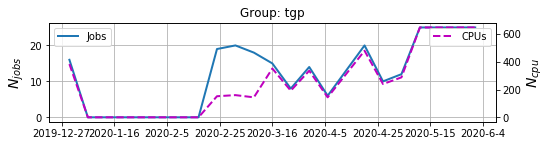

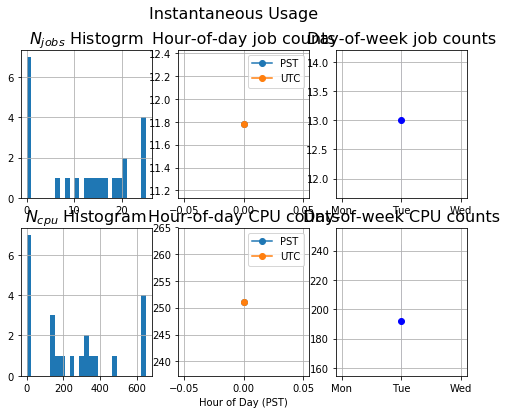

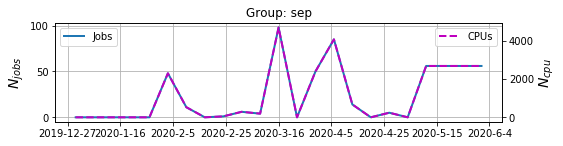

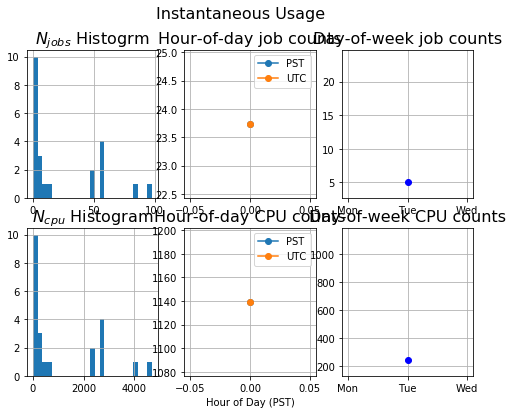

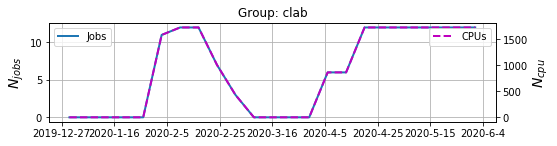

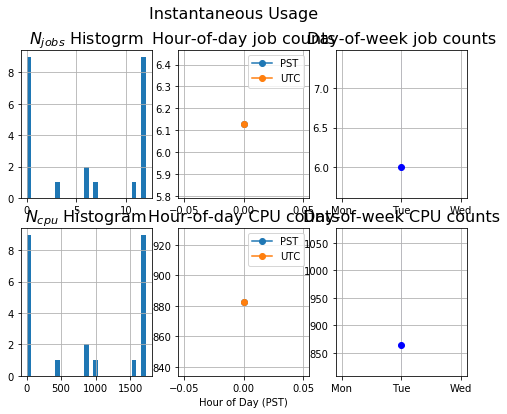

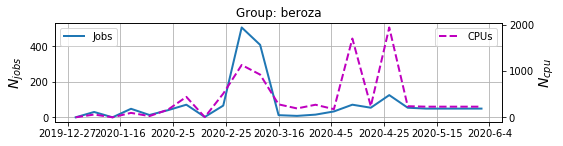

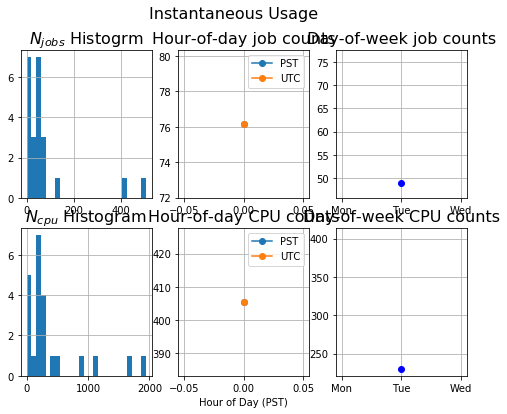

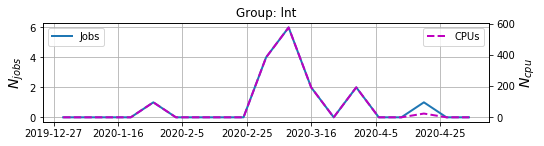

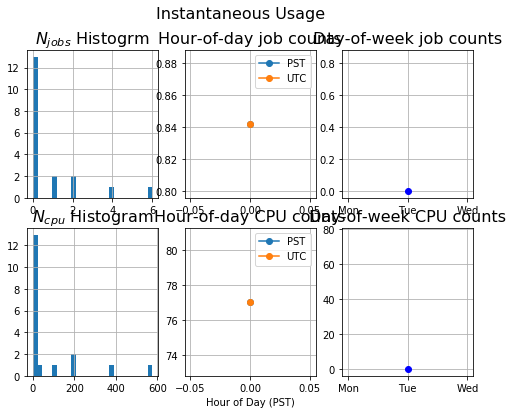

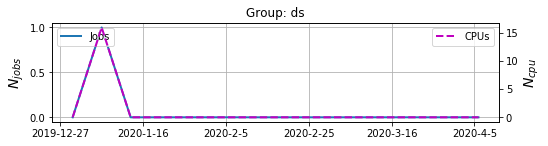

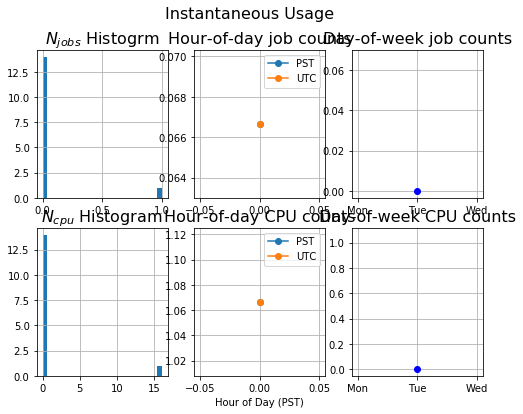

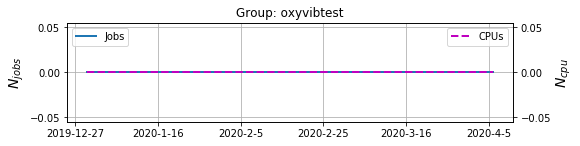

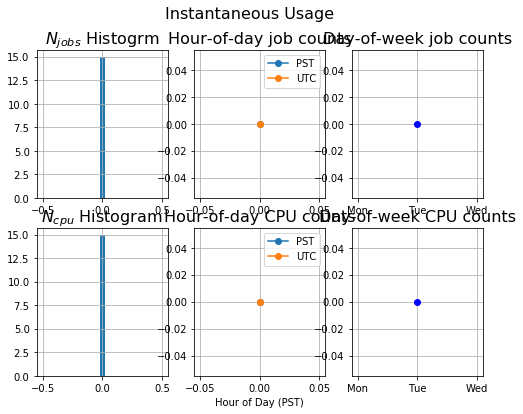

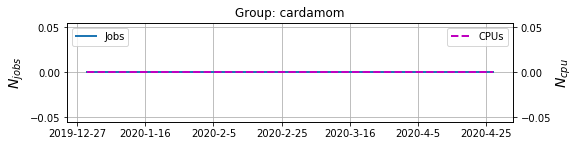

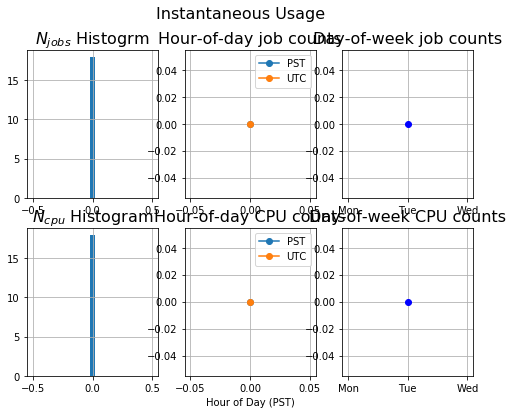

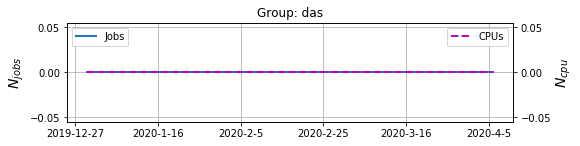

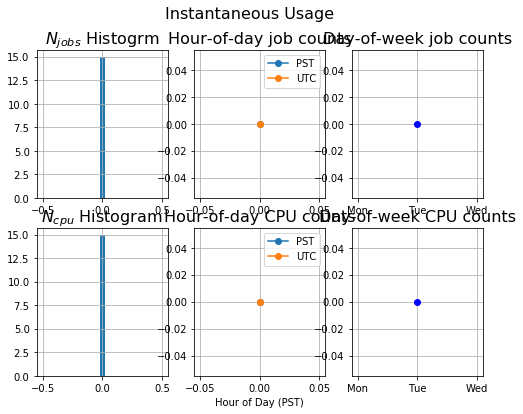

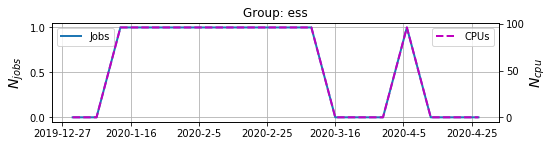

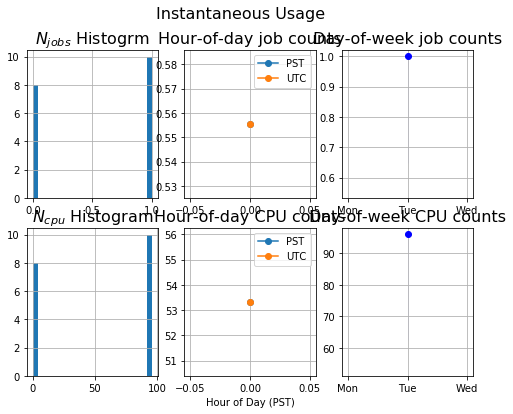

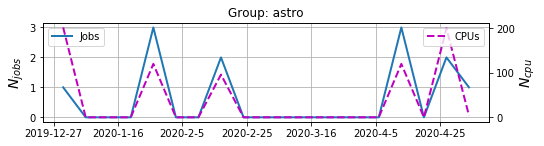

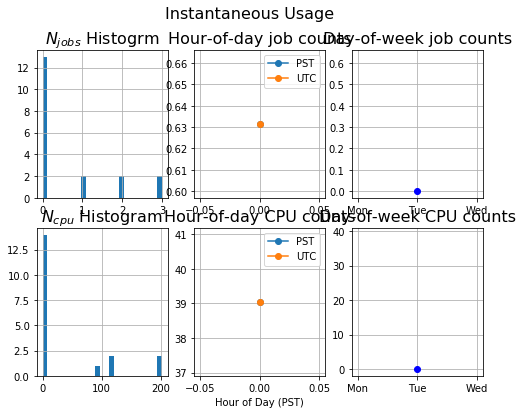

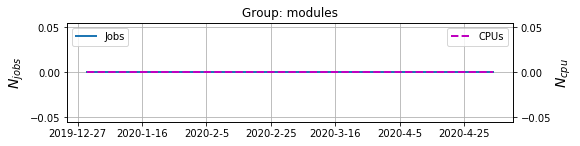

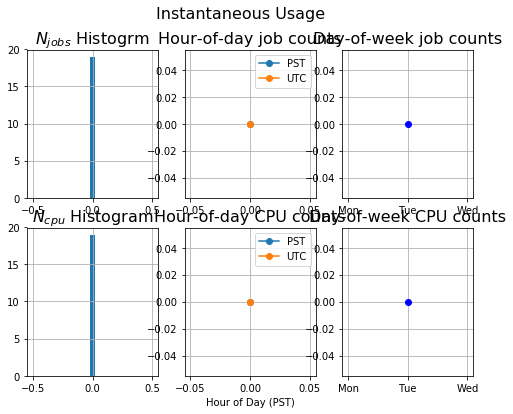

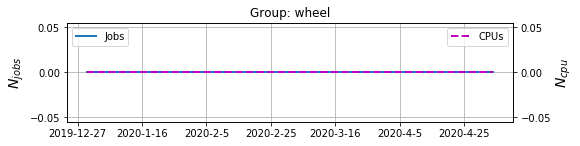

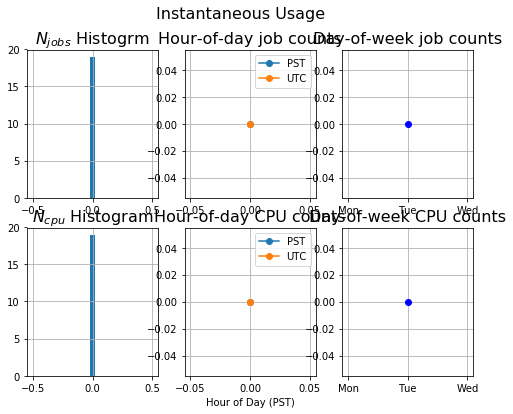

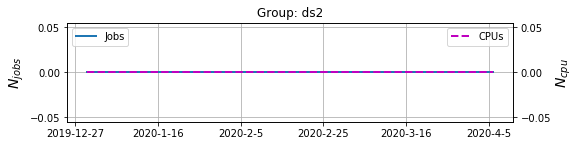

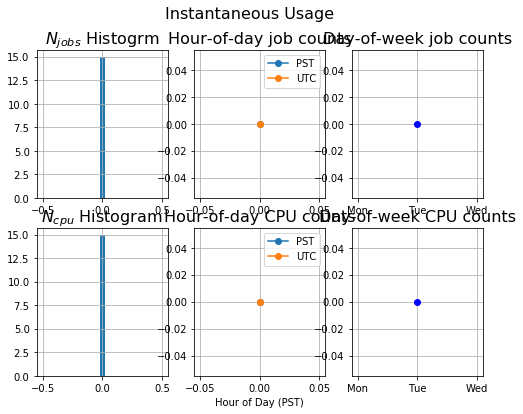

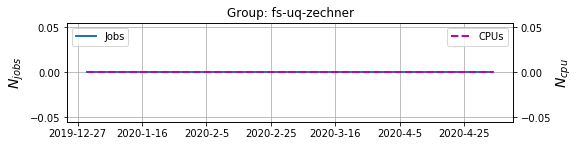

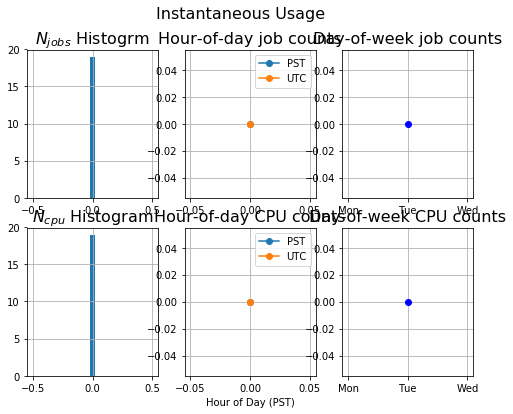

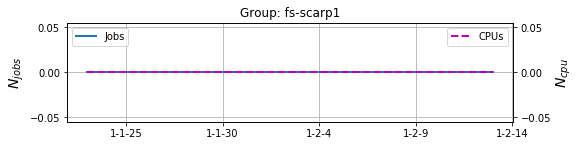

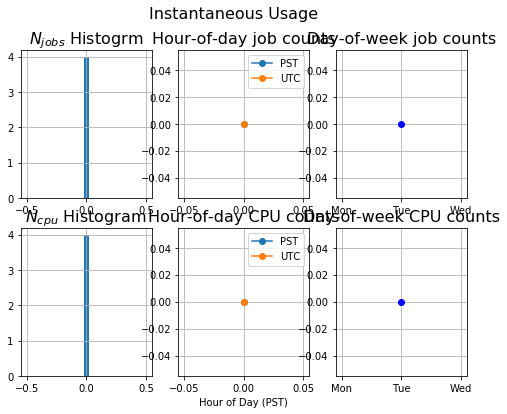

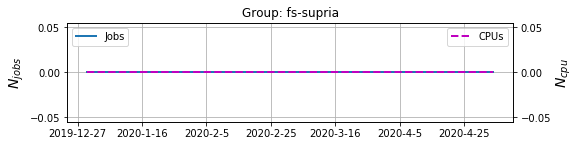

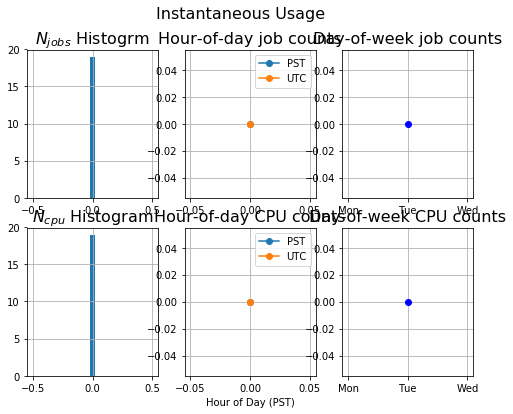

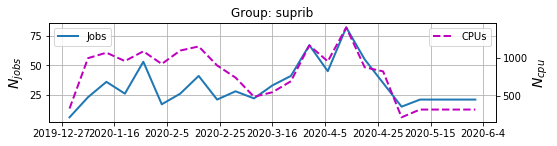

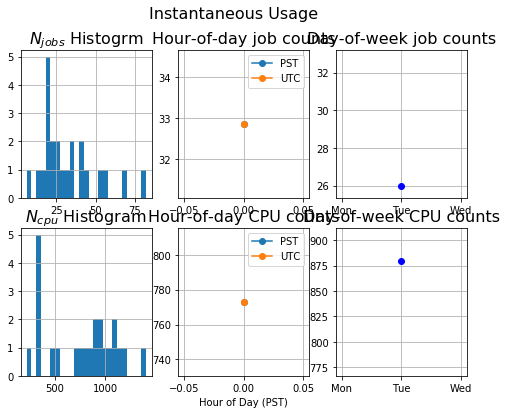

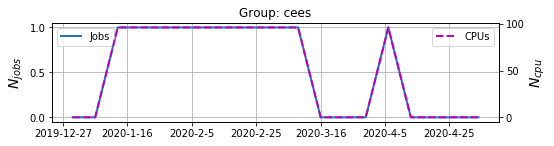

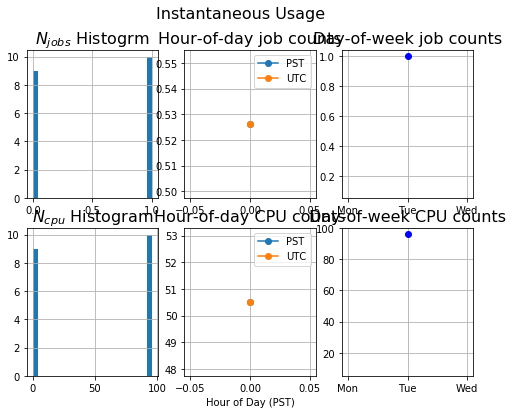

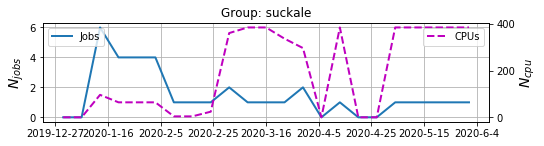

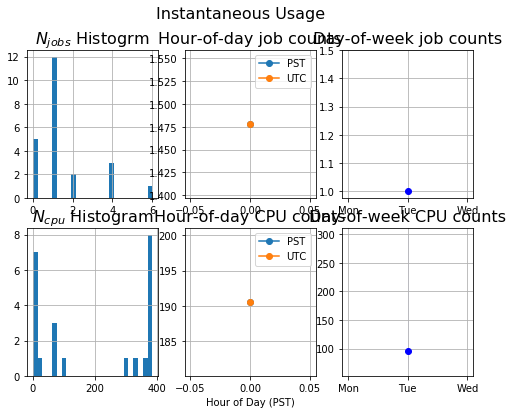

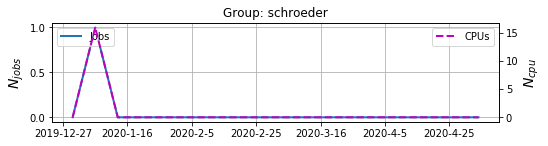

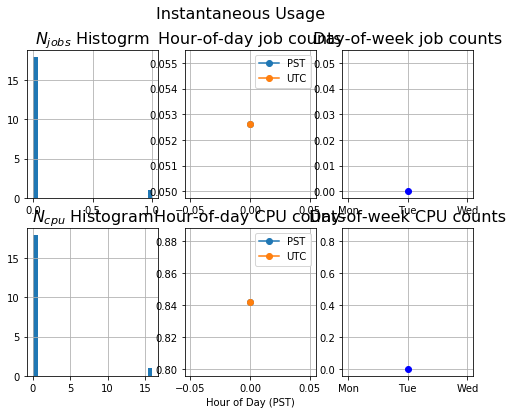

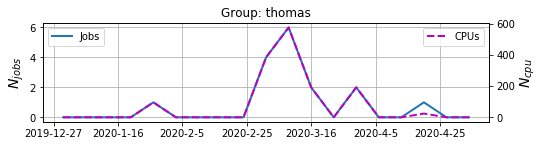

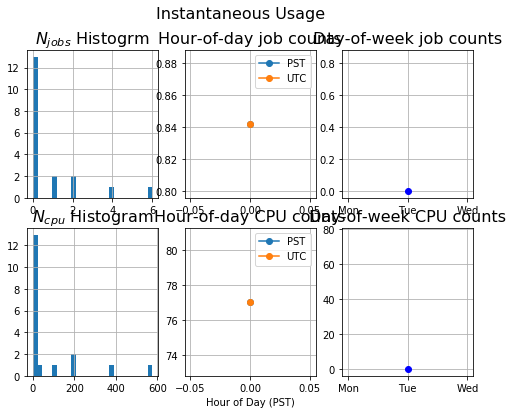

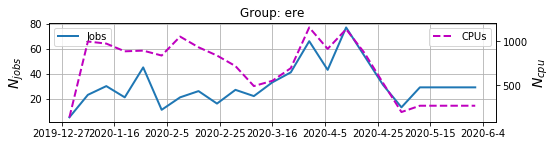

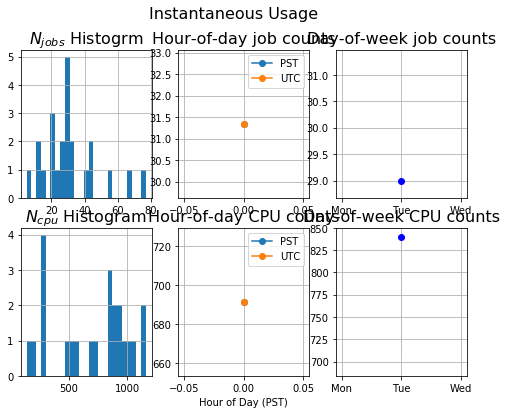

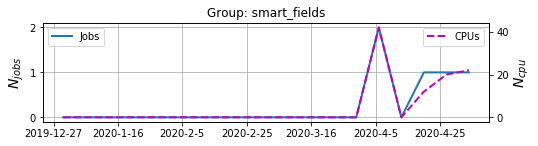

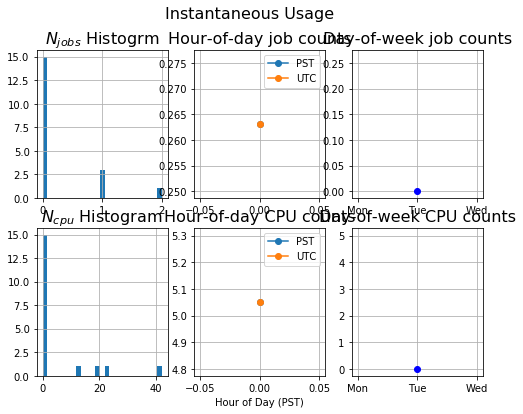

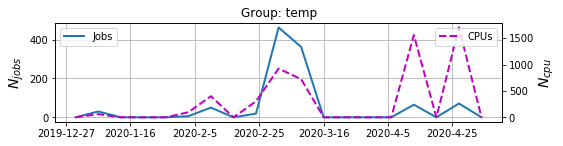

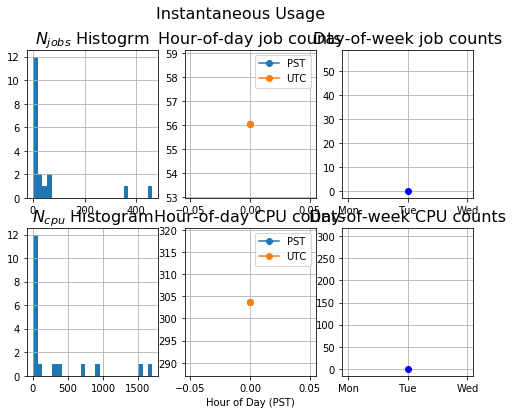

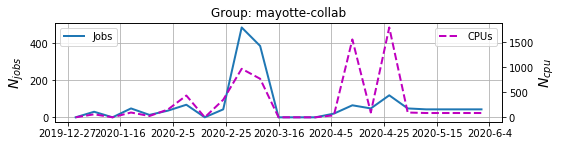

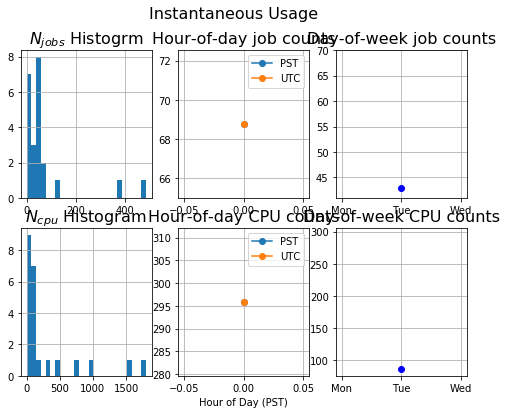

In [28]:
print('keys: ', groups.keys() )
for k, (ky,usrs) in enumerate(groups.items()):
    ix = numpy.where([s in usrs for s in sacct_mazama.jobs_summary['User'] ])[0]
    print('** DEBUG: sum(ix)={} / len(ix)={}'.format(numpy.sum(ix), len(ix)) )
    if len(ix)==0:
        print('[{}]:: no records.'.format(ky))
        continue
    #
    #
    #js_sub = numpy.array([tuple(rw) for rw in sacct_mazama.jobs_summary[ix]],
    #                                      dtype=sacct_mazama.jobs_summary.dtype)
    #print('*** js_sub: ', js_sub.shape, js_sub[0:3])
    #
    # this might actually work as intended. now. there were an odd combination of mistakes
    #. causing unpredictable behavior.
    #wkly_hrs = sacct_mazama.get_cpu_hours(bin_size=7, n_points=500, IX=ix)
    #wkly_hrs = sacct_mazama.get_cpu_hours(bin_size=7, n_points=500, IX=None,
    #                jobs_summary=sacct_mazama.jobs_summary,
    #                                      verbose=True)
    #
    act_jobs = sacct_mazama.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
    if len(act_jobs)==0:
        print('Group: {}:: no records.'.format(ky))
        continue
    #
    fg = plt.figure(figsize=(8,4))
    ax1 = plt.subplot('211')
    ax1.grid()
    ax1a = ax1.twinx()
    #ax2 = plt.subplot('212', sharex=ax1)
    #ax2.grid()
    #
    
    ax1.plot(act_jobs['time'], act_jobs['N_jobs'], ls='-', lw=2., marker='', label='Jobs')
    ax1a.plot(act_jobs['time'], act_jobs['N_cpu'], ls='--', lw=2., marker='', color='m', label='CPUs')
    ax1a.set_title('Group: {}'.format(ky))
    #
    #ax2.plot(wkly_hrs['time'], wkly_hrs['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
    #
    ax1.set_ylabel('$N_{jobs}$', size=14)
    ax1a.set_ylabel('$N_{cpu}$', size=14)
    #
    ax1.legend(loc='upper left')
    ax1a.legend(loc='upper right')
    #
    fg.canvas.draw()
    #
    # set ax3 labels to dates:
    # now format the datestrings...
    for ax in (ax1,):
        lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax.get_xticklabels()]
        ax.set_xticklabels(lbls)
    #
    # now, add the active jobs report:
    zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=(8,6), cpu_usage=act_jobs)
    #
    #sacct_mazama.active_cpu_jobs_per_day_hour_report(cpu_usage=act_jobs['N_cpu']
    #
    #if k>5: break
    #

In [ ]:
print(sacct_mazama.jobs_summary['End'].shape)
xx = sacct_mazama.jobs_summary['End']
print('** ', xx.shape, numpy.ndim(xx))
print('** ** ', xx[numpy.array([0,1,4,45,89,100])].shape)

In [ ]:
if True:
    with open(data_file_name, 'r') as fin:
        header_rw = fin.readline()
        print('*** ', header_rw)

    headers = header_rw.split('|')
    k_group = headers.index('Group')
    k_gid = headers.index('GID')
    #
    
    with open(data_file_name, 'r') as fin:
        for k,rw in enumerate(fin):
            #if 'dunham' in rw: print('** ', rw)
            #if 'dunham' in rw:
            #    rws = rw.split('|')
            #    print('** ', rws[k_group], rws[k_gid])
            if 'Partition_Limit' in rw:
                print('** ', rw)
                k+=1
                if k>10: break



In [ ]:
for rw in zip([1,2,3,4], [5,6,7,8], [9,10,11, 12]):
    print('* ', rw)

In [ ]:
A = numpy.array(numpy.zeros((10,3)), dtype=[('x', '>f8'), ('y', '>f8'), ('z', '>f8')])
print('A ', A)